In [1]:
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
import util
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
from sklearn.decomposition import PCA
from shap.plots import colors
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('dataset.pickle', 'rb') as f:
    X, y, feature_names, n_features, n_samples = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.log_odds.pickle', 'rb') as f:
        shap_values_a, shap_values_b = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

Now we define the functions to be explained:

In [6]:
predict_log_odds_a = lambda X: util.calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: util.calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X))

And filter non-finite predictions, because they would mess up the SHAP value generation:

In [7]:
mask = np.isfinite(predict_log_odds_a(X)) & np.isfinite(predict_log_odds_b(X))
n_nonfinite = np.sum(~mask)
if n_nonfinite > 0:
    X = X[mask, :]
    y = y[mask]
    n_samples = X.shape[0]
n_nonfinite

divide by zero encountered in log
divide by zero encountered in log


41

And now we calculate SHAP values for each function:

In [6]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(predict_log_odds_a)
shap_values_b = explain(predict_log_odds_b)

with open(f'shapvalues.soa.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.9 s, sys: 149 ms, total: 6.04 s
Wall time: 7.3 s


## Analyze

In [8]:
is_finite = np.all(np.isfinite(shap_values_a.values), axis=1) & np.all(np.isfinite(shap_values_b.values), axis=1)
n_nonfinite = np.sum(~is_finite)
n_nonfinite

0

In [9]:
shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data
feature_order = np.flip(shap_values_a_vs_b.abs.mean(axis=0).values.argsort())

In [10]:
indices = np.indices(y.shape).ravel()
diff_clf = MulticlassDifferenceClassifier(clf_a, clf_b)
diff_clf.fit(X, y)
binary_diff_clf = BinaryDifferenceClassifier(clf_a, clf_b)
binary_diff_clf.fit(X, y)
is_pred_equal = binary_diff_clf.predict(X)
is_pred_diff = ~is_pred_equal
pred = diff_clf.predict(X)
indices_pred_equal = np.argwhere(is_pred_equal).ravel()
if indices_pred_equal.shape[0] > 250:
    indices_pred_equal = resample(indices_pred_equal, replace=False, random_state=42, n_samples=250, stratify=pred[indices_pred_equal])
indices_pred_diff = np.argwhere(is_pred_diff).ravel()
if indices_pred_diff.shape[0] > 250:
    indices_pred_diff = resample(indices_pred_diff, replace=False, random_state=42, n_samples=250, stratify=pred[indices_pred_diff])
indices_sample = np.concatenate((indices_pred_equal, indices_pred_diff))

### Feature Importance

#### Bar Plots

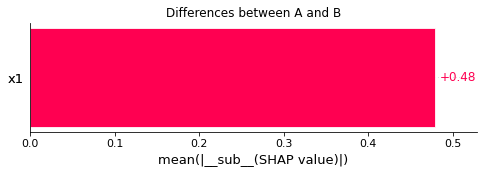

In [11]:
plt.title('Differences between A and B')
shap.plots.bar(shap_values_a_vs_b, order=feature_order, max_display=n_features)

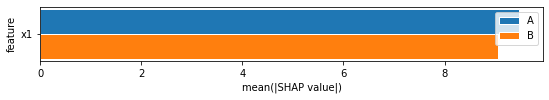

In [12]:
bar_width = 0.4
importances = np.array([shap_values_a.abs.mean(0).values.T, shap_values_b.abs.mean(0).values.T])
rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
fig, ax = plt.subplots(figsize=(9, n_features))
for name, rect, importance in zip(('A', 'B'), rects, importances):
    ax.barh(rect, importance, height=bar_width, edgecolor='white', label=name)
ax.set_ylabel('feature')
ax.set_xlabel('mean(|SHAP value|)')
ax.set_yticks([r + bar_width * (importances.shape[0] - 1)/2 for r in range(importances.shape[1])])
ax.set_yticklabels(feature_names)
ax.invert_yaxis()
ax.legend()
plt.show()

#### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

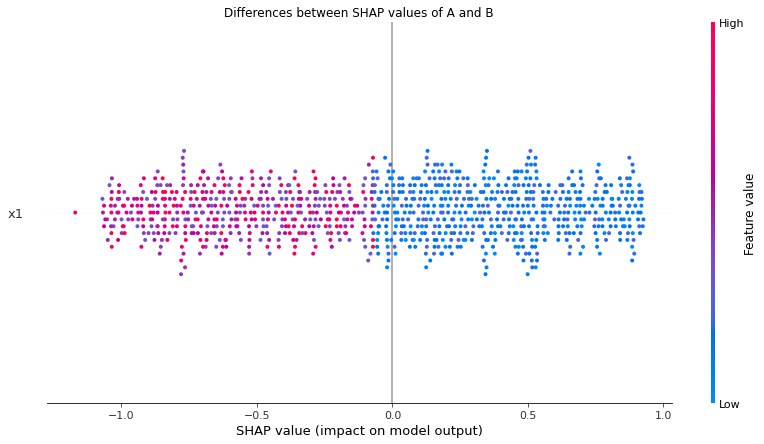

In [13]:
plt.title('Differences between SHAP values of A and B')
shap.plots.beeswarm(shap_values_a_vs_b, order=feature_order, plot_size=(14, 7))

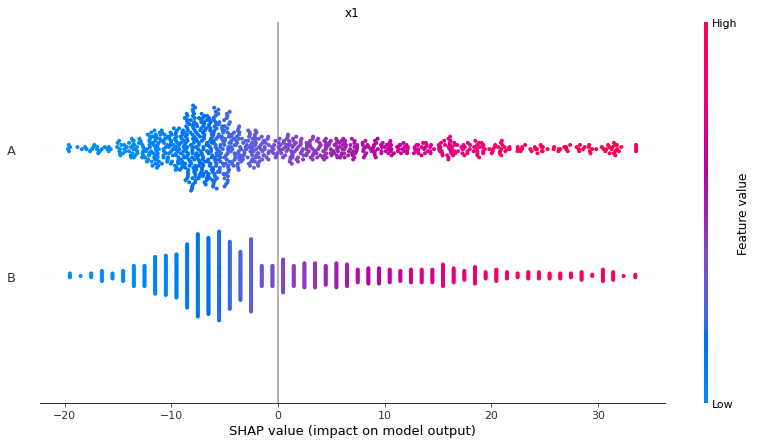

In [14]:
for feature_idx in feature_order:
    new_values = np.array([s.values[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    new_data = np.array([s.data[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    if shap_values_a.display_data is not None:
        new_display_data = np.array([s.display_data[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    else:
        new_display_data = None
    new_base_values = np.array([s.base_values for s in (shap_values_a, shap_values_b)]).T
    shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=['A', 'B'])
    shap.plots.beeswarm(shap_values_, plot_size=(14, 7), order=[0, 1], show=False)
    plt.title(feature_names[feature_idx])
    plt.show()

### Feature Effects

#### Partial Dependence Plots

Here we investigate the effect a feature has no the model output. Plot in blue are the instances where A and B predict the same label, plot over in red are instances where they differ. The last column shows the difference between the two classifiers' SHAP values.

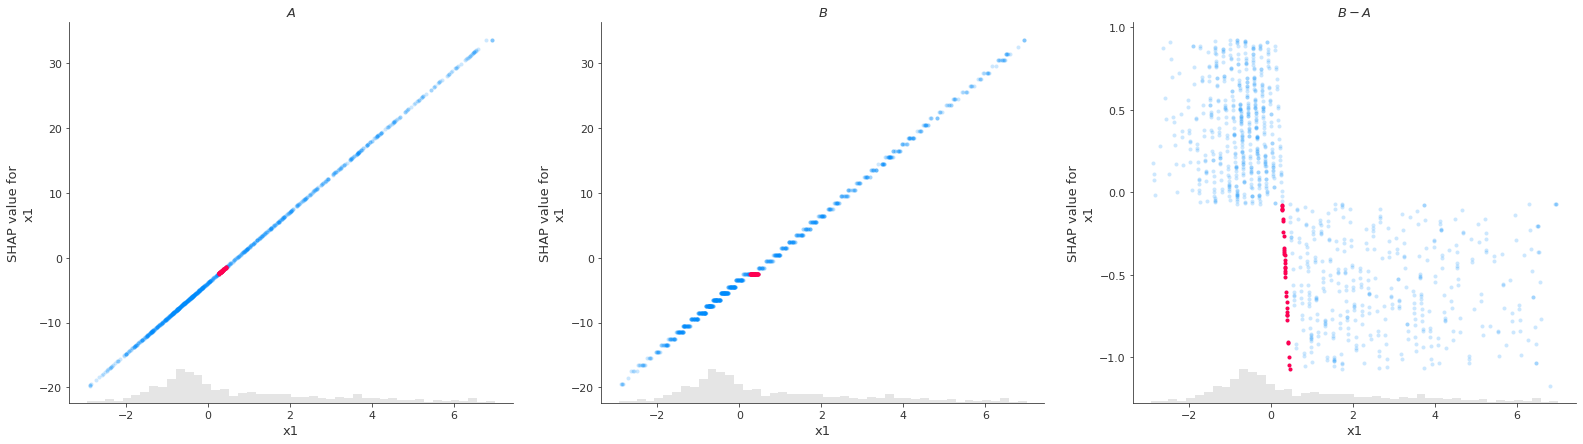

In [15]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2)
    for title, ax, shap_values in [('$A$', ax1, shap_values_a),
                                   ('$B$', ax2, shap_values_b),
                                   ('$B-A$', ax3, shap_values_a_vs_b)]:
        shap.plots.scatter(shap_values[:, feature],
                           ax=ax,
                           color=tuple(colors.blue_rgb),
                           alpha=0.2,
                           show=False)
        shap.plots.scatter(shap_values[is_pred_diff, feature],
                           title=title,
                           ax=ax,
                           color=tuple(colors.red_rgb),
                           hist=False,
                           show=False)
    i += n_columns
plt.show()

### Cluster

#### Force plots

In [16]:
shap_values_ = shap_values_a_vs_b[indices_sample]
data = shap_values_.display_data if shap_values_.display_data is not None else shap_values_.data
plot = shap.plots.force(
    base_value=shap_values_.base_values[0],
    shap_values=shap_values_.values,
    features=data,
    feature_names=feature_names)
instance_order = util.get_force_plot_ordering(plot)
display(plot)

In [17]:
for name, shap_values in zip(('A', 'B'), (shap_values_a, shap_values_b)):
    shap_values_ = shap_values[indices_sample]
    data = shap_values_.display_data if shap_values_.display_data is not None else shap_values_.data
    plot = shap.plots.force(base_value=shap_values_.base_values[0],
                            shap_values=shap_values_.values,
                            features=data,
                            feature_names=shap_values_.feature_names,
                            out_names=name, ordering_keys=instance_order)
    display(plot)

#### Heatmaps

SHAP heatmaps provide a way to cluster instances, using the hclust algorithm.

Classifier A:

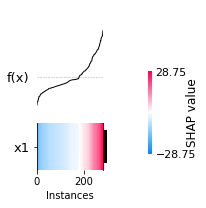

In [18]:
shap.plots.heatmap(shap_values_a[indices_sample], max_display=n_features, feature_order=feature_order)

Classifier B:

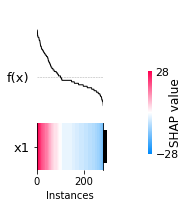

In [19]:
shap.plots.heatmap(shap_values_b[indices_sample], max_display=n_features, feature_order=feature_order)

Differences between A and B:

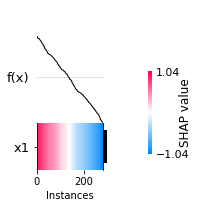

In [20]:
shap.plots.heatmap(shap_values_a_vs_b[indices_sample], max_display=n_features, feature_order=feature_order)

#### Decision plots

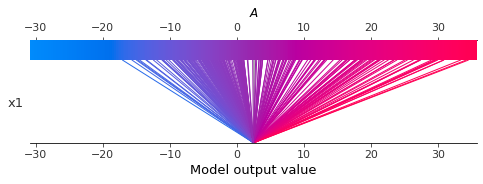

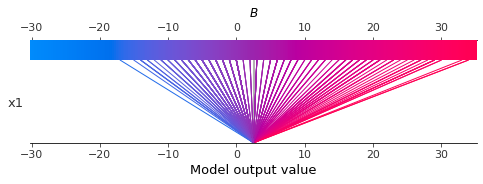

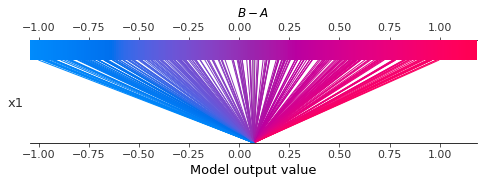

In [21]:
for name, shap_values in (('A', shap_values_a), ('B', shap_values_b), ('B-A', shap_values_a_vs_b)):
    shap_values_ = shap_values[indices_sample]
    shap.plots.decision(shap_values_.base_values[0],
                        shap_values_.values,
                        feature_names=feature_names.tolist(),
                        title=f'${name}$')